# Reading the dataset and printing the head values

In [1]:
import pandas as pd


df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# **Applying Pre-Processing to The Data "Removing HTML tags, Lowercasing, Removing panctuation and numbers, tokinaization, removing stopwords and Lemmitaization"** 

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    #removing HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # 3. Lowercase
    text = text.lower()
    
    # 4. Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 5. Tokenize
    words = word_tokenize(text)
    
    # 6. Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    return " ".join(words)

# Apply preprocessing
df['clean_review'] = df['review'].apply(preprocess_text)

# Check results
print(df[['review', 'clean_review']].head())


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                        clean_review  
0  one reviewer mentioned watching oz episode you...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically there family little boy jake think t...  
4  petter matteis love time money visually stunni...  


# Applying TF-IDF

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=15000,    # more features
    ngram_range=(1, 2),    # unigrams + bigrams
    min_df=5,              # ignore very rare words
    max_df=0.7             # ignore overly common words
)

X = tfidf.fit_transform(df['clean_review'])

y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

print("Improved TF-IDF matrix shape:", X.shape)


Improved TF-IDF matrix shape: (50000, 15000)


# Classifing using Logistic Regresion

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8954

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7411
           1       0.89      0.91      0.90      7589

    accuracy                           0.90     15000
   macro avg       0.90      0.90      0.90     15000
weighted avg       0.90      0.90      0.90     15000



# Naive Bayes Classification

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))



Naive Bayes Accuracy: 0.8704

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87      7411
           1       0.87      0.88      0.87      7589

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000



# Ploting and comparing between the accuracies of the two models

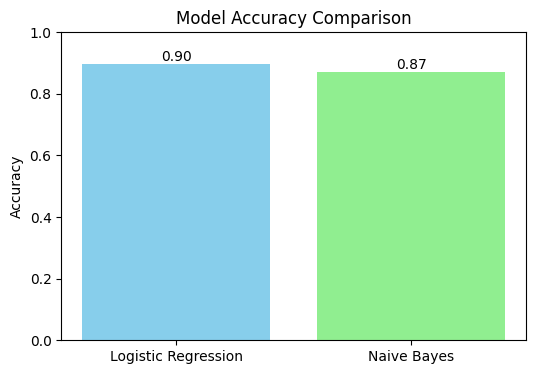

In [6]:
import matplotlib.pyplot as plt


models = ['Logistic Regression', 'Naive Bayes']
accuracies = [lr_accuracy, nb_accuracy]

plt.figure(figsize=(6,4))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.ylim(0, 1)  
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')

for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', fontsize=10)

plt.show()


# Visualizing the common Positive and Negative words

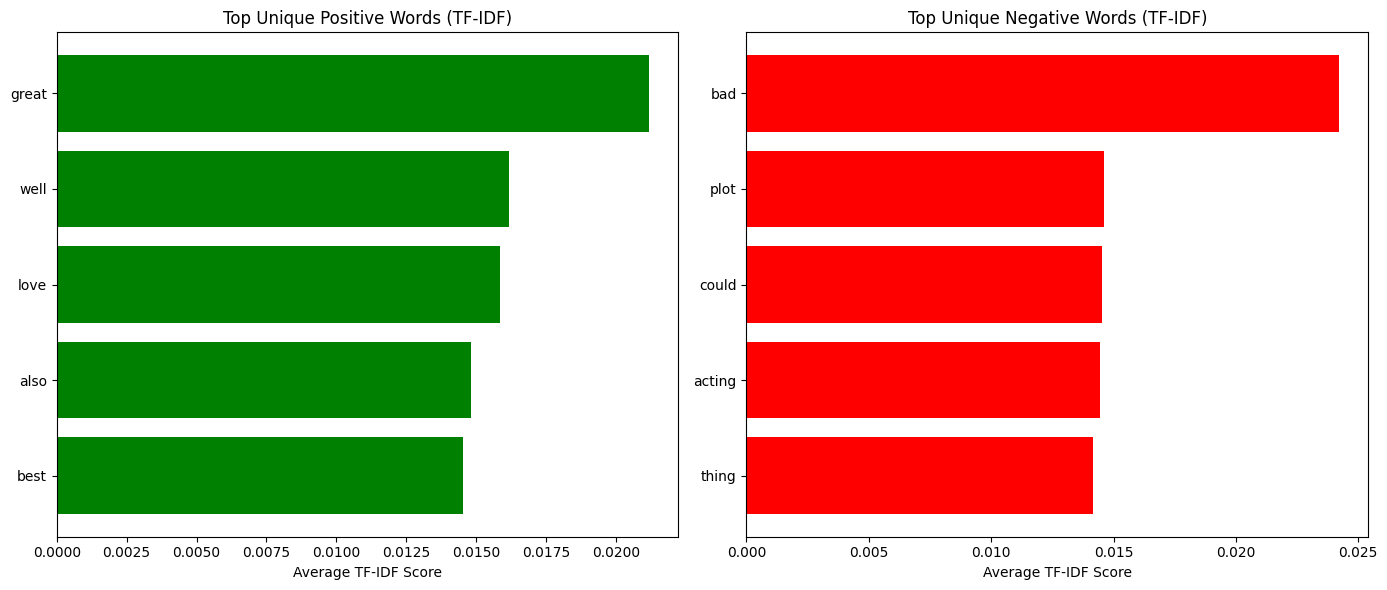

In [7]:
import numpy as np
import matplotlib.pyplot as plt

y_array = y.to_numpy()

# Get feature names from TF-IDF
feature_names = np.array(tfidf.get_feature_names_out())

# Separate TF-IDF features for positive and negative reviews
X_pos = X[y_array == 1]
X_neg = X[y_array == 0]

pos_mean = np.asarray(X_pos.mean(axis=0)).ravel()
neg_mean = np.asarray(X_neg.mean(axis=0)).ravel()

# Get top N words for each sentiment before filtering
top_n = 40  
pos_idx = pos_mean.argsort()[-top_n:][::-1]
neg_idx = neg_mean.argsort()[-top_n:][::-1]

pos_words = set(feature_names[pos_idx])
neg_words = set(feature_names[neg_idx])

# Remove common words
unique_pos = pos_words - neg_words
unique_neg = neg_words - pos_words

unique_pos_scores = {word: pos_mean[np.where(feature_names == word)[0][0]] for word in unique_pos}
unique_neg_scores = {word: neg_mean[np.where(feature_names == word)[0][0]] for word in unique_neg}

# Select top 5 unique words for each sentiment
top_pos = sorted(unique_pos_scores.items(), key=lambda x: x[1], reverse=True)[:5]
top_neg = sorted(unique_neg_scores.items(), key=lambda x: x[1], reverse=True)[:5]

top_pos_words, top_pos_scores = zip(*top_pos)
top_neg_words, top_neg_scores = zip(*top_neg)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.barh(top_pos_words[::-1], top_pos_scores[::-1], color='green')
plt.title("Top Unique Positive Words (TF-IDF)")
plt.xlabel("Average TF-IDF Score")

plt.subplot(1,2,2)
plt.barh(top_neg_words[::-1], top_neg_scores[::-1], color='red')
plt.title("Top Unique Negative Words (TF-IDF)")
plt.xlabel("Average TF-IDF Score")

plt.tight_layout()
plt.show()
